# United States License Plate Classification by State

### Here I test take multiple approches to the problem:
* transfer learning with a resnet18 backbone
* OCR using text similarity for classification
* CLIP zero shot classification
* CLIP few shot classification

In [35]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image, ImageDraw
from tempfile import TemporaryDirectory
import torchvision.transforms.functional as F
import random
from sklearn.model_selection import train_test_split


# Load and augment dataset
Here the plate images are loaded from the dataset and padded to square images

Data augmentations are applied to the training set for better performance

In [36]:

data_dir = "plates"


class PadToSquare:
    def __call__(self, img):
        w, h = img.size
        longest = max(w, h)
        pad_w = (longest - w) // 2
        pad_h = (longest - h) // 2
        padding = (pad_w, pad_h, longest - w - pad_w, longest - h - pad_h)
        return F.pad(img, padding, fill=0)  # black padding
    
class RandomPlateCover:
    """
    Randomly adds rectangular covers to simulate occlusions on license plates.
    """
    def __init__(self, coverage_ratio=0.2, p=0.5):
        """
        coverage_ratio: max fraction of image to cover
        p: probability of applying the occlusion
        """
        self.coverage_ratio = coverage_ratio
        self.p = p

    def __call__(self, img):
        if random.random() > self.p:
            return img

        img = img.copy()
        draw = ImageDraw.Draw(img)
        w, h = img.size

        # Random width and height for the cover
        cover_w = int(random.uniform(0.1, self.coverage_ratio) * w)
        cover_h = int(random.uniform(0.1, self.coverage_ratio) * h)

        # Random position
        x0 = random.randint(0, w - cover_w)
        y0 = random.randint(0, h - cover_h)
        x1 = x0 + cover_w
        y1 = y0 + cover_h

        # Draw a black (or gray) rectangle
        draw.rectangle([x0, y0, x1, y1], fill=(0, 0, 0))

        return img

train_transforms = transforms.Compose([
    PadToSquare(),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


val_transforms = transforms.Compose([
    PadToSquare(),
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

the original dataset needs to be resplit as the original split is approximately 95% 2.5% 2.5% between training validation and testing

So here we resplit the dataset with a 70% 15% 15% split

In [37]:
# Load and combine data
train_dataset_raw = datasets.ImageFolder(os.path.join(data_dir, "train"))
val_dataset_raw = datasets.ImageFolder(os.path.join(data_dir, "valid"))
test_dataset_raw = datasets.ImageFolder(os.path.join(data_dir, "test"))

all_data = ConcatDataset([train_dataset_raw, val_dataset_raw, test_dataset_raw])

# Get all labels
all_labels = [all_data[i][1] for i in range(len(all_data))]
all_indices = list(range(len(all_data)))

# Stratified split
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    all_indices, all_labels, 
    test_size=0.30,  # 30% for val+test
    stratify=all_labels,
    random_state=42
)

val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,  # Split the 30% equally between val and test
    stratify=temp_labels,
    random_state=42
)

print(f"Stratified split - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

# Create datasets with transforms
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.indices)

train_dataset = TransformSubset(all_data, train_indices, train_transforms)
val_dataset = TransformSubset(all_data, val_indices, val_transforms)
test_dataset = TransformSubset(all_data, test_indices, val_transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = train_dataset_raw.classes

Stratified split - Train: 6104, Val: 1308, Test: 1309


In [45]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


visualization for training and validation sets

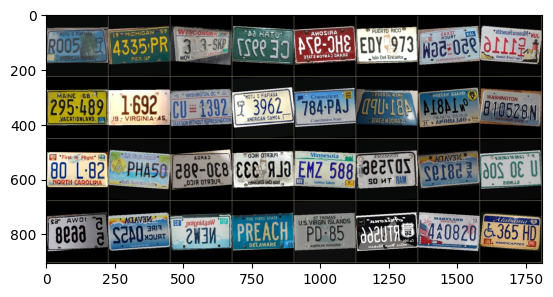

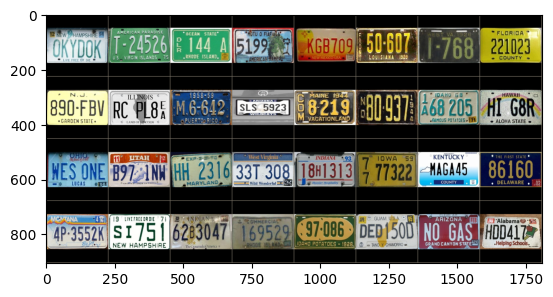

In [46]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # if title is not None:
    #     plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(val_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [47]:
def load_trained_model(model_path, num_classes, device):
    """Load a trained ResNet18 model from checkpoint"""
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    # Create model architecture
    model = models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    # Load weights
    try:
        state_dict = torch.load(model_path, map_location=device, weights_only=True)
        model.load_state_dict(state_dict)
        print(f"Model loaded successfully from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        raise
    
    # Move to device and set to eval mode
    model = model.to(device)
    model.eval()
    
    return model

model training process and accuracy plotting

In [48]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # Initialize history tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store metrics in history
                history[f'{phase}_loss'].append(epoch_loss)
                history[f'{phase}_acc'].append(epoch_acc.cpu().item())

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    
    # Plot training history
    plot_training_history(history, num_epochs)
    
    return model


def plot_training_history(history, num_epochs):
    """Plot training and validation metrics"""
    epochs = range(num_epochs)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot accuracy
    ax1.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    ax1.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax2.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

the first approch involves full fine tuning the resnet18 model

we change the last fully connected layer to output the number of classes we are using

In [49]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 2.8642 Acc: 0.3083
val Loss: 2.8447 Acc: 0.3257

Epoch 1/24
----------
train Loss: 1.4761 Acc: 0.6189
val Loss: 1.7518 Acc: 0.5359

Epoch 2/24
----------
train Loss: 0.8903 Acc: 0.7710
val Loss: 0.9476 Acc: 0.7538

Epoch 3/24
----------
train Loss: 0.5815 Acc: 0.8458
val Loss: 0.7799 Acc: 0.7951

Epoch 4/24
----------
train Loss: 0.3972 Acc: 0.8883
val Loss: 0.7791 Acc: 0.8050

Epoch 5/24
----------
train Loss: 0.2819 Acc: 0.9240
val Loss: 0.8217 Acc: 0.7905

Epoch 6/24
----------
train Loss: 0.2348 Acc: 0.9353
val Loss: 0.6334 Acc: 0.8448

Epoch 7/24
----------
train Loss: 0.0869 Acc: 0.9808
val Loss: 0.3153 Acc: 0.9258

Epoch 8/24
----------
train Loss: 0.0421 Acc: 0.9918
val Loss: 0.2991 Acc: 0.9312

Epoch 9/24
----------
train Loss: 0.0294 Acc: 0.9959
val Loss: 0.2922 Acc: 0.9350

Epoch 10/24
----------
train Loss: 0.0206 Acc: 0.9977
val Loss: 0.2877 Acc: 0.9365

Epoch 11/24
----------
train Loss: 0.0197 Acc: 0.9974
val Loss: 0.2867 Acc: 0.9358

Ep

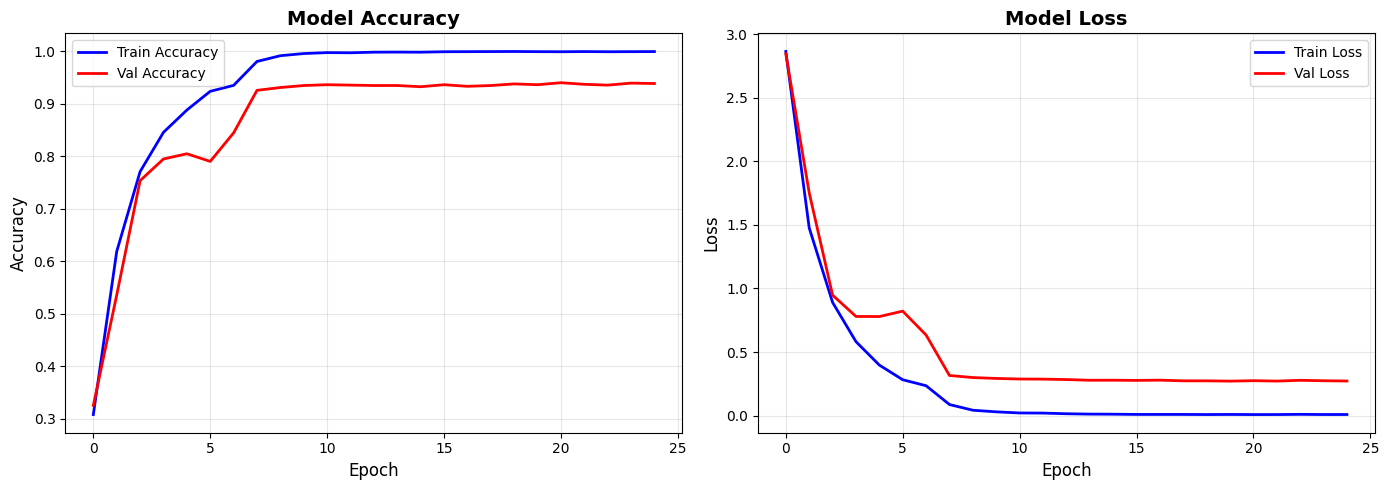

In [50]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [52]:
def plot_per_class_accuracy(class_correct, class_total, class_names):
    """
    Create a bar chart showing accuracy for each state/class and display it.
    
    Args:
        class_correct: dict mapping class index to number of correct predictions
        class_total: dict mapping class index to total predictions for that class
        class_names: list of class names (state names)
    """
    # Calculate accuracies
    accuracies = []
    labels = []
    
    for i in range(len(class_names)):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            accuracies.append(acc)
            labels.append(class_names[i])
        else:
            accuracies.append(0)
            labels.append(class_names[i])
    
    # Sort by accuracy for better visualization
    sorted_indices = np.argsort(accuracies)
    accuracies_sorted = [accuracies[i] for i in sorted_indices]
    labels_sorted = [labels[i] for i in sorted_indices]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Color code by accuracy level
    colors = ['red' if acc < 80 else 'orange' if acc < 90 else 'yellowgreen' if acc < 95 else 'green' 
              for acc in accuracies_sorted]
    
    # Create horizontal bar chart
    bars = ax.barh(range(len(labels_sorted)), accuracies_sorted, color=colors, alpha=0.7)
    
    # Customize
    ax.set_yticks(range(len(labels_sorted)))
    ax.set_yticklabels(labels_sorted, fontsize=8)
    ax.set_xlabel('Accuracy (%)', fontsize=12)
    ax.set_title('Per-State Classification Accuracy', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 105])
    ax.axvline(x=80, color='red', linestyle='--', alpha=0.5, label='80% threshold')
    ax.axvline(x=90, color='orange', linestyle='--', alpha=0.5, label='90% threshold')
    ax.grid(axis='x', alpha=0.3)
    ax.legend()
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
        ax.text(acc + 1, i, f'{acc:.1f}%', va='center', fontsize=7)
    
    plt.tight_layout()
    plt.show()  # Display instead of saving

In [53]:
def evaluate_test_set(model, dataloader, class_names):
    model.eval()
    running_corrects = 0
    total = 0
    
    # Track per-class performance
    class_correct = {i: 0 for i in range(len(class_names))}
    class_total = {i: 0 for i in range(len(class_names))}
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels).item()
            total += labels.size(0)
            
            # Per-class accuracy tracking
            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = preds[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

    # Overall accuracy
    accuracy = running_corrects / total
    print(f"\n{'='*60}")
    print(f"Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Correct: {running_corrects}/{total}")
    print(f"{'='*60}")
    
    # Per-class accuracy
    print(f"\nPer-Class Accuracy:")
    print(f"{'-'*60}")
    print(f"{'Class':<20s} {'Accuracy':<10s} {'Correct/Total':<15s}")
    print(f"{'-'*60}")
    
    for i, class_name in enumerate(class_names):
        if class_total[i] > 0:
            class_acc = class_correct[i] / class_total[i]
            print(f"{class_name:<20s} {class_acc:.4f} ({class_acc*100:>5.2f}%)  {class_correct[i]:>3d}/{class_total[i]:<3d}")
        else:
            print(f"{class_name:<20s} {'N/A':<10s} {'0/0':<15s}")
    
    print(f"{'-'*60}\n")

    plot_per_class_accuracy(class_correct, class_total, class_names)
    
    return accuracy

evaluate the model on the testing set and save the model


Overall Test Accuracy: 0.9213 (92.13%)
Correct: 1206/1309

Per-Class Accuracy:
------------------------------------------------------------
Class                Accuracy   Correct/Total  
------------------------------------------------------------
ALABAMA              0.8400 (84.00%)   21/25 
ALASKA               0.9167 (91.67%)   22/24 
AMERICAN SAMOA       0.9565 (95.65%)   22/23 
ARIZONA              0.9545 (95.45%)   21/22 
ARKANSAS             0.9259 (92.59%)   25/27 
CALIFORNIA           0.9200 (92.00%)   23/25 
CNMI                 1.0000 (100.00%)   14/14 
COLORADO             0.9524 (95.24%)   20/21 
CONNECTICUT          0.8696 (86.96%)   20/23 
DELAWARE             0.8636 (86.36%)   19/22 
FLORIDA              0.9583 (95.83%)   23/24 
GEORGIA              1.0000 (100.00%)   22/22 
GUAM                 0.9231 (92.31%)   24/26 
HAWAI                0.9130 (91.30%)   21/23 
IDAHO                0.9565 (95.65%)   22/23 
ILLINOIS             0.9130 (91.30%)   21/23 
INDIANA     

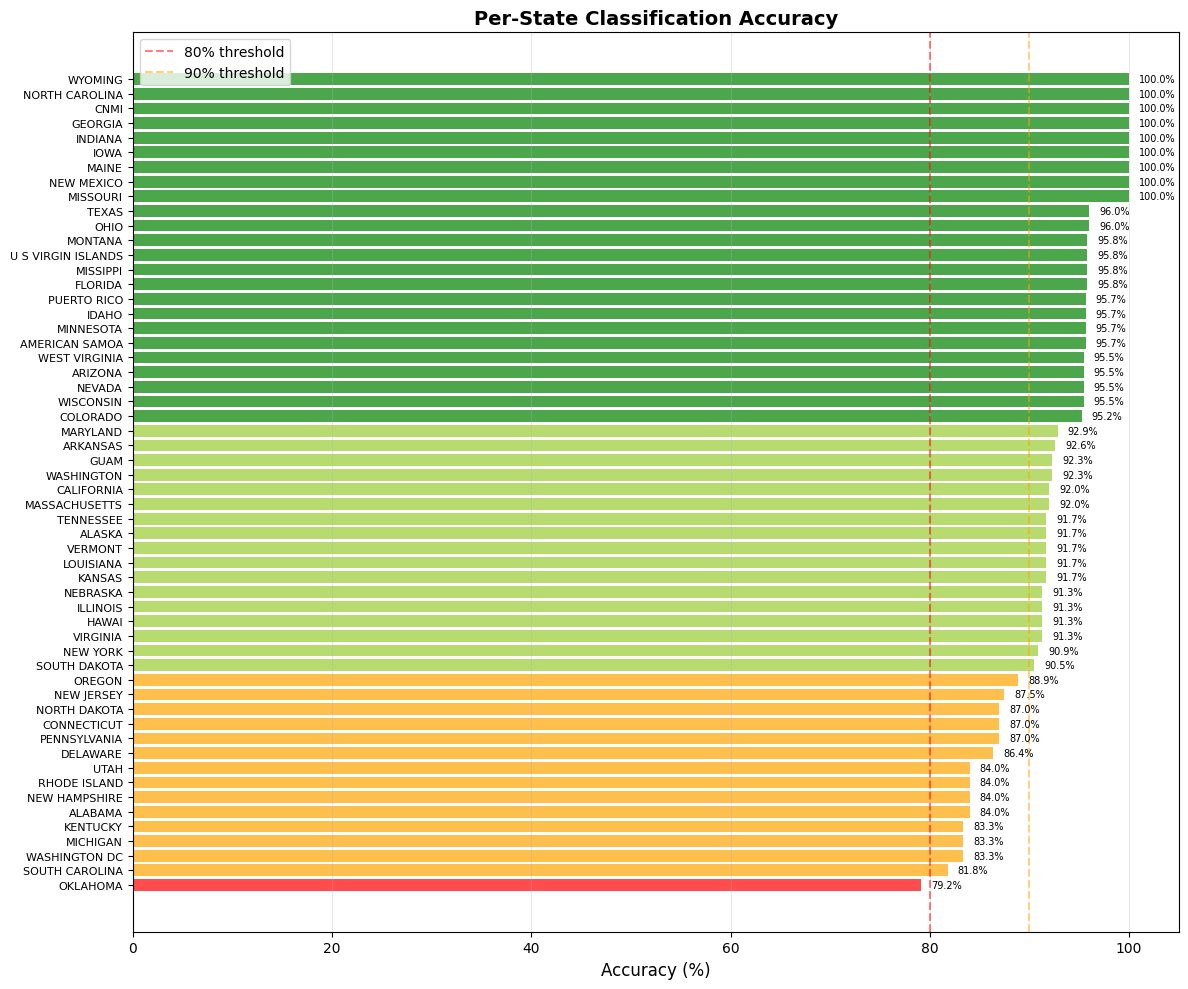

0.9213139801375095

In [54]:
evaluate_test_set(model_ft, test_loader, class_names)
# torch.save(model_ft.state_dict(), "plate_classifier_better_split.pth")

In [15]:
print(class_names)

['ALABAMA', 'ALASKA', 'AMERICAN SAMOA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'CNMI', 'COLORADO', 'CONNECTICUT', 'DELAWARE', 'FLORIDA', 'GEORGIA', 'GUAM', 'HAWAI', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA', 'PUERTO RICO', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'U S VIRGIN ISLANDS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON', 'WASHINGTON DC', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING']


test the model with an arbitrary image

Predicted class: CALIFORNIA


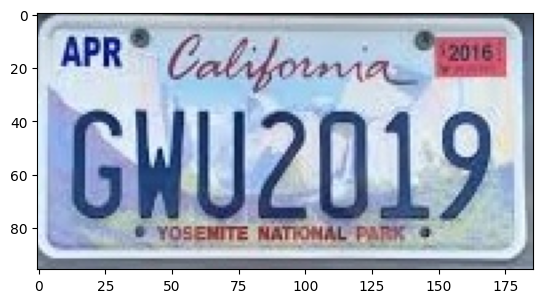

In [67]:
img_path = "test_images/california.jpg"
image = Image.open(img_path).convert("RGB")

# Apply preprocessing
preprocess = transforms.Compose([
    PadToSquare(),                   # your custom padding class
    transforms.Resize((224, 224)),   # match model input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # add batch dimension
input_batch = input_batch.to(device)

with torch.no_grad():
    outputs = model_ft(input_batch)
    _, predicted = torch.max(outputs, 1)

pred_class = class_names[predicted.item()]
plt.imshow(image)
print(f"Predicted class: {pred_class}")

train model while only training last fully connected layer

Epoch 0/24
----------
train Loss: 3.7379 Acc: 0.1250
val Loss: 3.2845 Acc: 0.2317

Epoch 1/24
----------
train Loss: 3.0277 Acc: 0.3024
val Loss: 2.8690 Acc: 0.3456

Epoch 2/24
----------
train Loss: 2.6812 Acc: 0.3820
val Loss: 2.6626 Acc: 0.3792

Epoch 3/24
----------
train Loss: 2.4792 Acc: 0.4128
val Loss: 2.5128 Acc: 0.4213

Epoch 4/24
----------
train Loss: 2.3223 Acc: 0.4510
val Loss: 2.4887 Acc: 0.3960

Epoch 5/24
----------
train Loss: 2.2315 Acc: 0.4615
val Loss: 2.4000 Acc: 0.4297

Epoch 6/24
----------
train Loss: 2.1457 Acc: 0.4831
val Loss: 2.3853 Acc: 0.4350

Epoch 7/24
----------
train Loss: 1.9980 Acc: 0.5264
val Loss: 2.2738 Acc: 0.4549

Epoch 8/24
----------
train Loss: 1.9648 Acc: 0.5446
val Loss: 2.2769 Acc: 0.4625

Epoch 9/24
----------
train Loss: 1.9663 Acc: 0.5324
val Loss: 2.2670 Acc: 0.4618

Epoch 10/24
----------
train Loss: 1.9718 Acc: 0.5344
val Loss: 2.2643 Acc: 0.4633

Epoch 11/24
----------
train Loss: 1.9470 Acc: 0.5388
val Loss: 2.2635 Acc: 0.4541

Ep

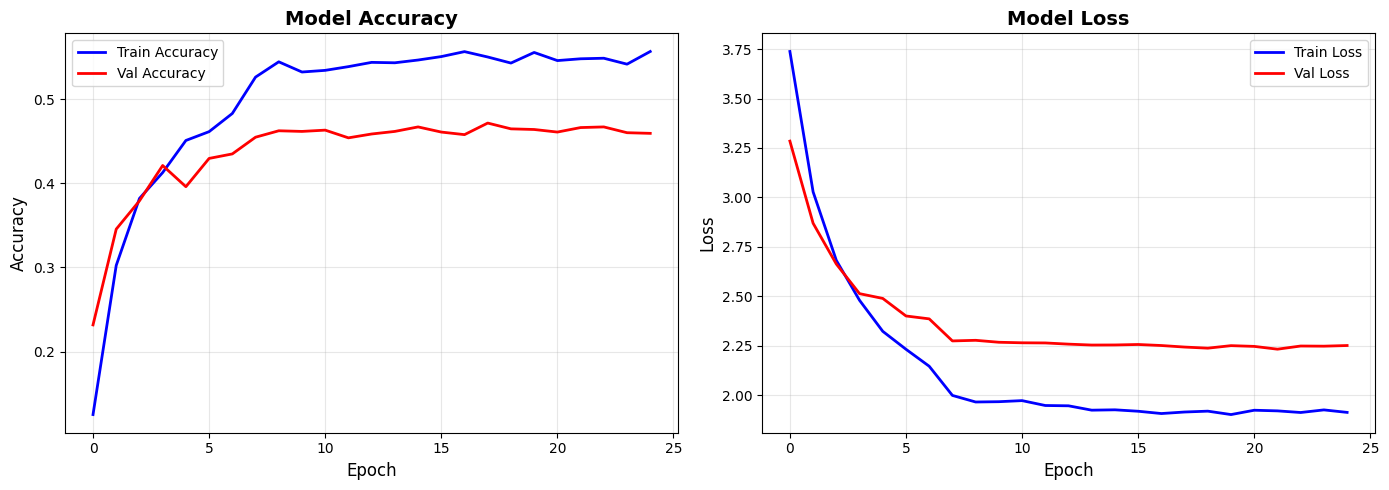


Overall Test Accuracy: 0.4599 (45.99%)
Correct: 602/1309

Per-Class Accuracy:
------------------------------------------------------------
Class                Accuracy   Correct/Total  
------------------------------------------------------------
ALABAMA              0.2400 (24.00%)    6/25 
ALASKA               0.4583 (45.83%)   11/24 
AMERICAN SAMOA       0.4783 (47.83%)   11/23 
ARIZONA              0.2273 (22.73%)    5/22 
ARKANSAS             0.5556 (55.56%)   15/27 
CALIFORNIA           0.3200 (32.00%)    8/25 
CNMI                 0.4286 (42.86%)    6/14 
COLORADO             0.5714 (57.14%)   12/21 
CONNECTICUT          0.6087 (60.87%)   14/23 
DELAWARE             0.8182 (81.82%)   18/22 
FLORIDA              0.5833 (58.33%)   14/24 
GEORGIA              0.4545 (45.45%)   10/22 
GUAM                 0.4231 (42.31%)   11/26 
HAWAI                0.3913 (39.13%)    9/23 
IDAHO                0.7391 (73.91%)   17/23 
ILLINOIS             0.1304 (13.04%)    3/23 
INDIANA        

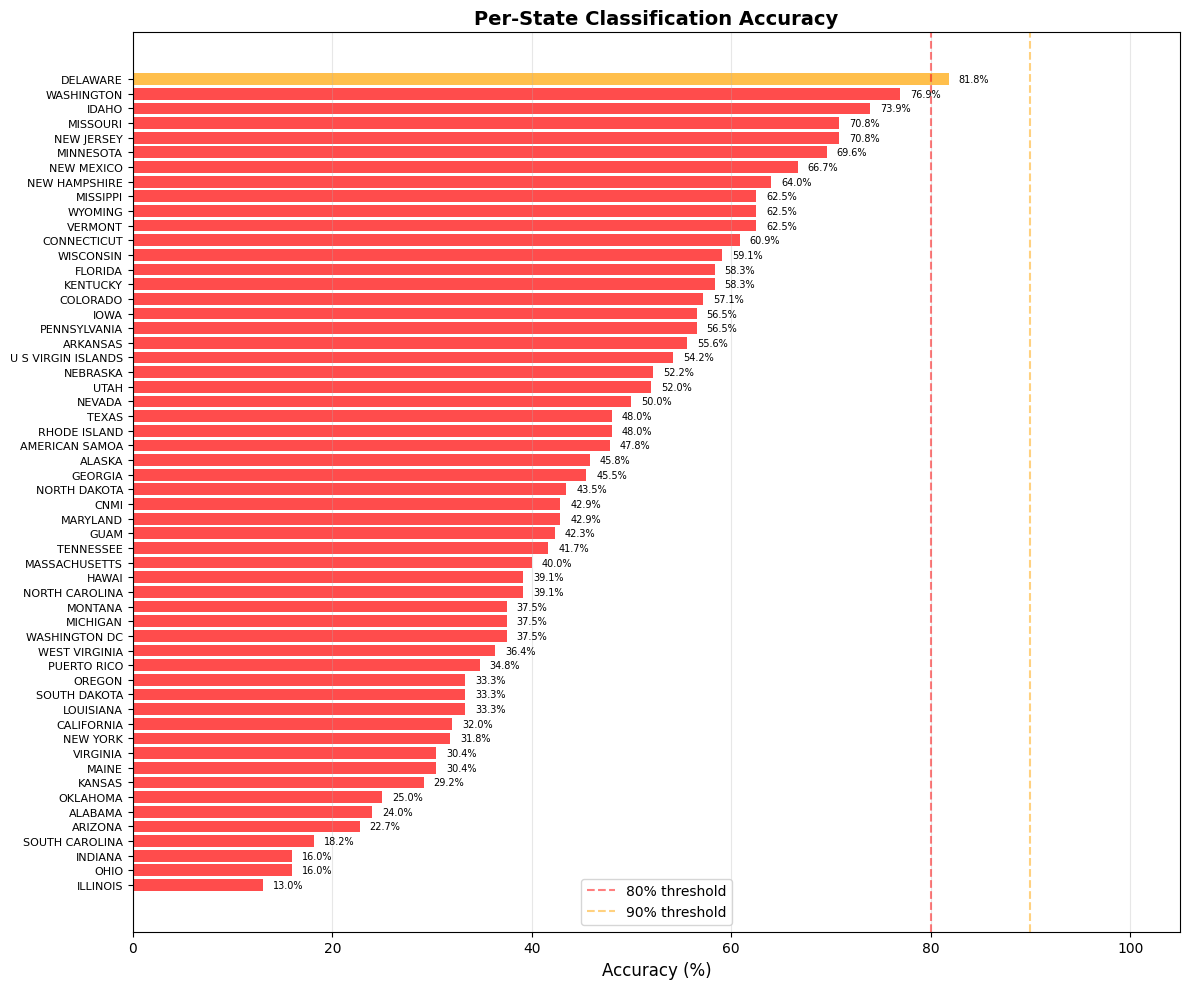

0.45989304812834225

In [56]:
model_ft_frozen_bb = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft_frozen_bb.fc.in_features

# Freeze all pretrained parameters
for param in model_ft_frozen_bb.parameters():
    param.requires_grad = False

model_ft_frozen_bb.fc = nn.Linear(num_ftrs, len(class_names))

model_ft_frozen_bb = model_ft_frozen_bb.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft_frozen_bb.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft_frozen_bb = train_model(model_ft_frozen_bb, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

evaluate_test_set(model_ft_frozen_bb, test_loader, class_names)

Swap last fully connected layer with linear classifier

Epoch 0/24
----------
train Loss: 4.0176 Acc: 0.0239
val Loss: 3.9540 Acc: 0.0642

Epoch 1/24
----------
train Loss: 3.8791 Acc: 0.0603
val Loss: 3.7142 Acc: 0.0948

Epoch 2/24
----------
train Loss: 3.6421 Acc: 0.1109
val Loss: 3.3940 Acc: 0.1904

Epoch 3/24
----------
train Loss: 3.4463 Acc: 0.1563
val Loss: 3.1873 Acc: 0.2531

Epoch 4/24
----------
train Loss: 3.3123 Acc: 0.1840
val Loss: 3.1239 Acc: 0.2378

Epoch 5/24
----------
train Loss: 3.1944 Acc: 0.2092
val Loss: 2.9728 Acc: 0.2890

Epoch 6/24
----------
train Loss: 3.1437 Acc: 0.2133
val Loss: 2.9370 Acc: 0.2836

Epoch 7/24
----------
train Loss: 3.0052 Acc: 0.2529
val Loss: 2.8399 Acc: 0.3081

Epoch 8/24
----------
train Loss: 2.9836 Acc: 0.2528
val Loss: 2.8075 Acc: 0.3173

Epoch 9/24
----------
train Loss: 2.9585 Acc: 0.2657
val Loss: 2.7951 Acc: 0.3211

Epoch 10/24
----------
train Loss: 2.9632 Acc: 0.2605
val Loss: 2.7790 Acc: 0.3242

Epoch 11/24
----------
train Loss: 2.9342 Acc: 0.2741
val Loss: 2.7772 Acc: 0.3219

Ep

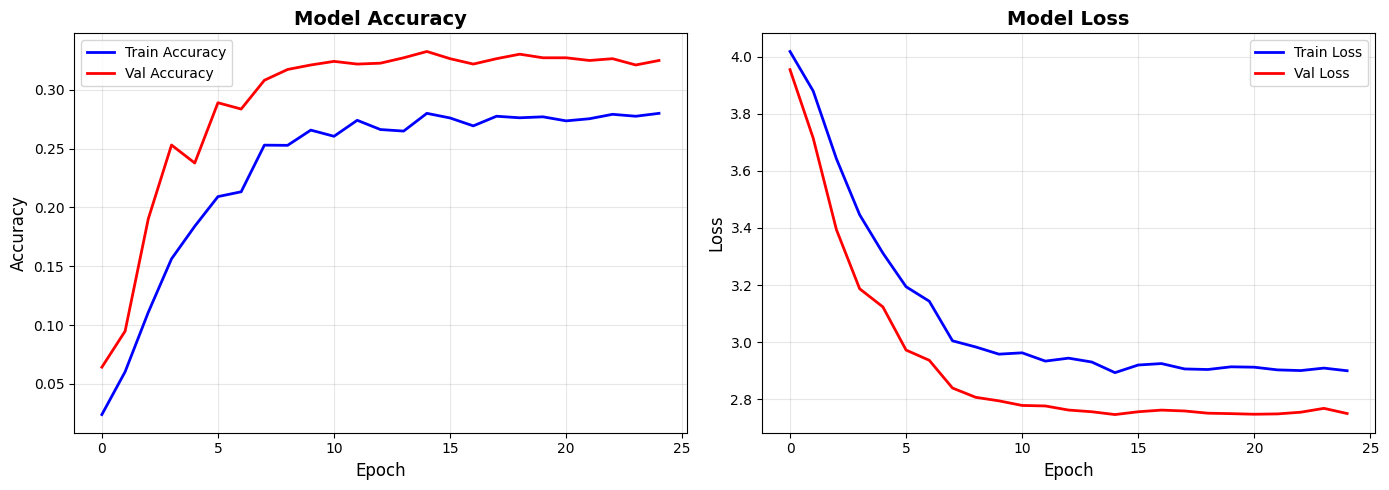


Overall Test Accuracy: 0.3369 (33.69%)
Correct: 441/1309

Per-Class Accuracy:
------------------------------------------------------------
Class                Accuracy   Correct/Total  
------------------------------------------------------------
ALABAMA              0.1600 (16.00%)    4/25 
ALASKA               0.3333 (33.33%)    8/24 
AMERICAN SAMOA       0.5652 (56.52%)   13/23 
ARIZONA              0.0909 ( 9.09%)    2/22 
ARKANSAS             0.4444 (44.44%)   12/27 
CALIFORNIA           0.2400 (24.00%)    6/25 
CNMI                 0.1429 (14.29%)    2/14 
COLORADO             0.4762 (47.62%)   10/21 
CONNECTICUT          0.5217 (52.17%)   12/23 
DELAWARE             0.7273 (72.73%)   16/22 
FLORIDA              0.3333 (33.33%)    8/24 
GEORGIA              0.2273 (22.73%)    5/22 
GUAM                 0.3077 (30.77%)    8/26 
HAWAI                0.3913 (39.13%)    9/23 
IDAHO                0.4783 (47.83%)   11/23 
ILLINOIS             0.0000 ( 0.00%)    0/23 
INDIANA        

0.33689839572192515

In [18]:
model_ft_frozen_bb_lc = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft_frozen_bb_lc.fc.in_features

# Freeze all pretrained parameters
for param in model_ft_frozen_bb_lc.parameters():
    param.requires_grad = False

model_ft_frozen_bb_lc.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, len(class_names))
)

model_ft_frozen_bb_lc = model_ft_frozen_bb_lc.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft_frozen_bb_lc.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft_frozen_bb_lc = train_model(model_ft_frozen_bb_lc, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

evaluate_test_set(model_ft_frozen_bb_lc, test_loader, class_names)

train only last fully connected layer and last residual block

Epoch 0/24
----------
train Loss: 2.9542 Acc: 0.3141
val Loss: 1.9682 Acc: 0.5153

Epoch 1/24
----------
train Loss: 1.5347 Acc: 0.6366
val Loss: 1.3936 Acc: 0.6529

Epoch 2/24
----------
train Loss: 0.9372 Acc: 0.7713
val Loss: 1.1433 Acc: 0.7034

Epoch 3/24
----------
train Loss: 0.6016 Acc: 0.8557
val Loss: 1.0700 Acc: 0.7294

Epoch 4/24
----------
train Loss: 0.3612 Acc: 0.9178
val Loss: 1.0090 Acc: 0.7424

Epoch 5/24
----------
train Loss: 0.2249 Acc: 0.9487
val Loss: 0.9783 Acc: 0.7584

Epoch 6/24
----------
train Loss: 0.1417 Acc: 0.9720
val Loss: 0.9798 Acc: 0.7576

Epoch 7/24
----------
train Loss: 0.0822 Acc: 0.9866
val Loss: 0.8900 Acc: 0.7836

Epoch 8/24
----------
train Loss: 0.0591 Acc: 0.9930
val Loss: 0.8851 Acc: 0.7791

Epoch 9/24
----------
train Loss: 0.0550 Acc: 0.9934
val Loss: 0.8688 Acc: 0.7882

Epoch 10/24
----------
train Loss: 0.0448 Acc: 0.9962
val Loss: 0.8639 Acc: 0.7898

Epoch 11/24
----------
train Loss: 0.0421 Acc: 0.9961
val Loss: 0.8552 Acc: 0.7898

Ep

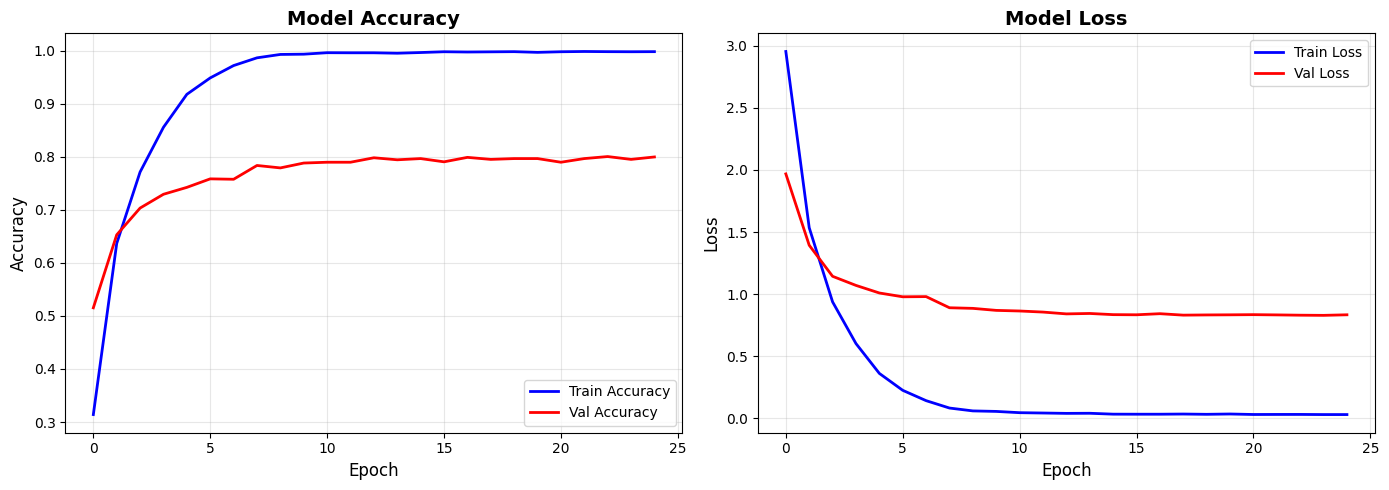


Overall Test Accuracy: 0.7976 (79.76%)
Correct: 1044/1309

Per-Class Accuracy:
------------------------------------------------------------
Class                Accuracy   Correct/Total  
------------------------------------------------------------
ALABAMA              0.7200 (72.00%)   18/25 
ALASKA               0.7500 (75.00%)   18/24 
AMERICAN SAMOA       0.8261 (82.61%)   19/23 
ARIZONA              0.5909 (59.09%)   13/22 
ARKANSAS             0.8148 (81.48%)   22/27 
CALIFORNIA           0.7600 (76.00%)   19/25 
CNMI                 0.8571 (85.71%)   12/14 
COLORADO             0.9524 (95.24%)   20/21 
CONNECTICUT          0.8696 (86.96%)   20/23 
DELAWARE             0.8182 (81.82%)   18/22 
FLORIDA              0.9167 (91.67%)   22/24 
GEORGIA              0.9091 (90.91%)   20/22 
GUAM                 0.8846 (88.46%)   23/26 
HAWAI                0.7391 (73.91%)   17/23 
IDAHO                0.9130 (91.30%)   21/23 
ILLINOIS             0.6522 (65.22%)   15/23 
INDIANA       

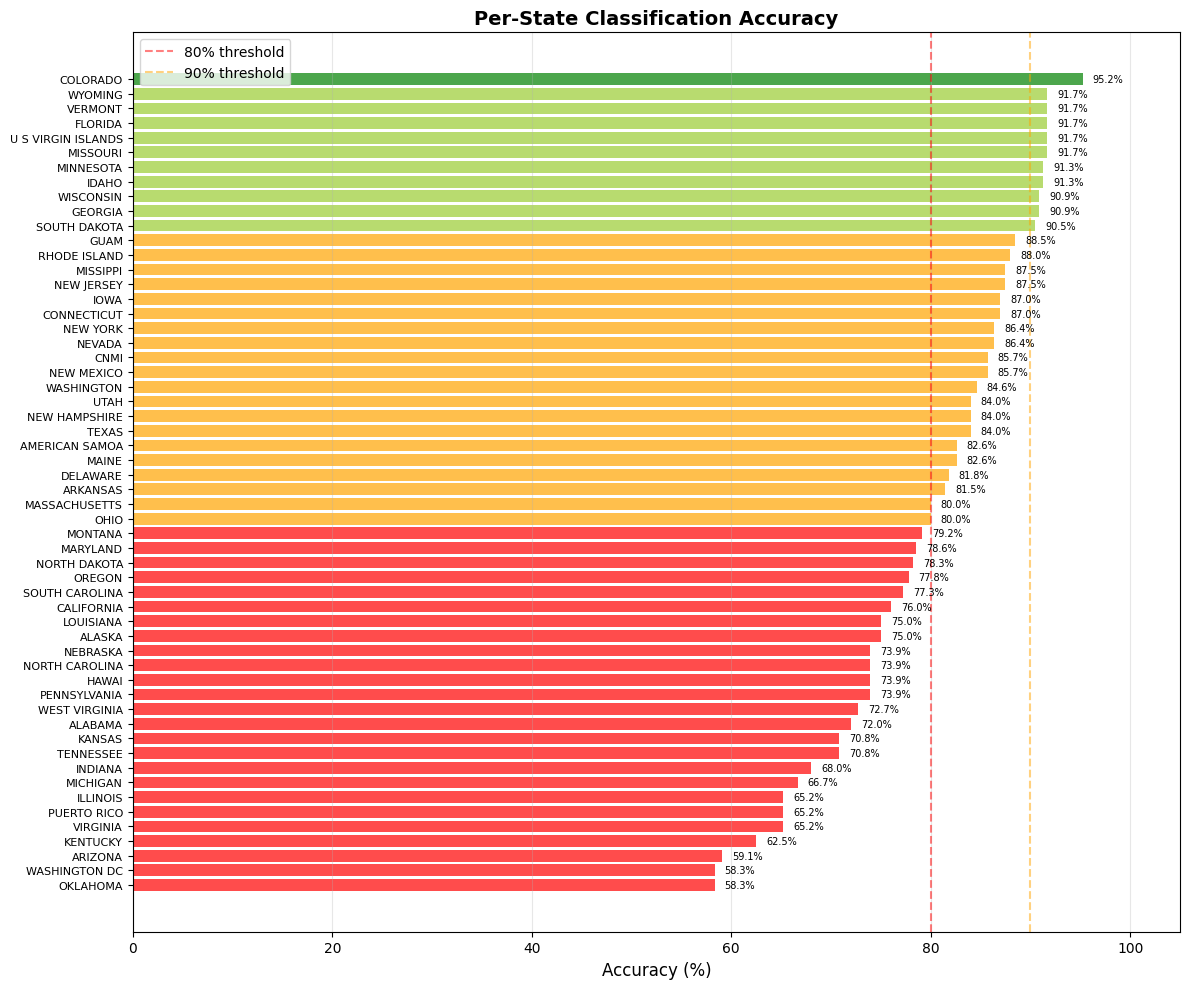

0.7975553857906799

In [57]:
model_ft_frozen_bb_el4 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft_frozen_bb_el4.fc.in_features

# Freeze all pretrained parameters
for param in model_ft_frozen_bb_el4.parameters():
    param.requires_grad = False

# Unfreeze layer4 (last residual block)
for param in model_ft_frozen_bb_el4.layer4.parameters():
    param.requires_grad = True

# Replace final layer
model_ft_frozen_bb_el4.fc = nn.Linear(num_ftrs, len(class_names))

model_ft_frozen_bb_el4 = model_ft_frozen_bb_el4.to(device)

criterion = nn.CrossEntropyLoss()

# Use differential learning rates
optimizer_ft = optim.Adam([
    {'params': model_ft_frozen_bb_el4.layer4.parameters(), 'lr': 0.0001},
    {'params': model_ft_frozen_bb_el4.fc.parameters(), 'lr': 0.001}
])

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft_frozen_bb_el4 = train_model(model_ft_frozen_bb_el4, criterion, optimizer_ft, 
                                      exp_lr_scheduler, num_epochs=25)

evaluate_test_set(model_ft_frozen_bb_el4, test_loader, class_names)

# Compare results with OCR

In [64]:
import easyocr
from difflib import SequenceMatcher
import numpy as np
from tqdm import tqdm

def text_similarity(text1, text2):
    """Calculate similarity between two strings (0 to 1)"""
    return SequenceMatcher(None, text1.lower(), text2.lower()).ratio()

def classify_plate_with_ocr(image, reader, state_names):
    """
    Classify a license plate image using OCR and text similarity to state names
    
    Args:
        image: PIL Image or numpy array
        reader: EasyOCR reader instance
        state_names: list of state names to match against
    
    Returns:
        predicted_state: best matching state name
        confidence: similarity score (0-1)
        detected_texts: list of all detected text boxes
    """
    # Convert PIL Image to numpy array if needed
    if hasattr(image, 'convert'):
        image = np.array(image.convert('RGB'))
    
    # Read text from image
    results = reader.readtext(image)
    
    if not results:
        # No text detected
        return None, 0.0, []
    
    # Extract just the text from results (results format: [bbox, text, confidence])
    detected_texts = [text for (bbox, text, conf) in results]
    
    # Find best matching state for any detected text
    best_state = None
    best_similarity = 0.0
    
    for detected_text in detected_texts:
        for state_name in state_names:
            similarity = text_similarity(detected_text, state_name)
            if similarity > best_similarity:
                best_similarity = similarity
                best_state = state_name
    
    return best_state, best_similarity, detected_texts


def evaluate_ocr_baseline(test_dataset, class_names, similarity_threshold=0.5):
    """
    Evaluate OCR-based classification on test dataset
    
    Args:
        test_dataset: PyTorch dataset with (image, label) pairs
        class_names: list of class names (state names)
        similarity_threshold: minimum similarity to make a prediction
    
    Returns:
        accuracy: overall accuracy
        results: detailed results for analysis
    """
    # Initialize EasyOCR reader (English language)
    print("Initializing EasyOCR reader...")
    reader = easyocr.Reader(['en'], gpu=True)
    
    correct = 0
    total = 0
    no_prediction = 0
    
    results = {
        'predictions': [],
        'ground_truth': [],
        'confidences': [],
        'detected_texts': []
    }
    
    print(f"Evaluating OCR baseline on {len(test_dataset)} images...")
    
    for idx in tqdm(range(len(test_dataset))):
        # Get image and true label
        image, true_label = test_dataset[idx]
        
        # Convert tensor back to PIL Image for OCR
        # Denormalize if normalized
        if isinstance(image, torch.Tensor):
            # Denormalize using ImageNet stats
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = image * std + mean
            image = torch.clamp(image, 0, 1)
            
            # Convert to PIL Image
            image = transforms.ToPILImage()(image)
        
        # Classify using OCR
        predicted_state, confidence, detected_texts = classify_plate_with_ocr(
            image, reader, class_names
        )
        
        # Store results
        results['detected_texts'].append(detected_texts)
        results['confidences'].append(confidence)
        results['ground_truth'].append(class_names[true_label])
        
        if predicted_state is None or confidence < similarity_threshold:
            # No confident prediction
            results['predictions'].append(None)
            no_prediction += 1
        else:
            results['predictions'].append(predicted_state)
            
            # Check if correct
            if predicted_state == class_names[true_label]:
                correct += 1
        
        total += 1
    
    # Calculate metrics
    accuracy = correct / total if total > 0 else 0
    prediction_rate = (total - no_prediction) / total if total > 0 else 0
    
    print(f"\n{'='*50}")
    print(f"OCR Baseline Results:")
    print(f"{'='*50}")
    print(f"Total samples: {total}")
    print(f"Correct predictions: {correct}")
    print(f"No prediction (low confidence): {no_prediction}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Prediction rate: {prediction_rate:.4f} ({prediction_rate*100:.2f}%)")
    print(f"{'='*50}\n")
    
    return accuracy, results


def analyze_ocr_errors(results, class_names, n_examples=10):
    """Analyze and display OCR classification errors"""
    
    print("Sample Errors:")
    print("-" * 80)
    
    error_count = 0
    for i in range(len(results['predictions'])):
        pred = results['predictions'][i]
        true = results['ground_truth'][i]
        conf = results['confidences'][i]
        texts = results['detected_texts'][i]
        
        if pred != true:
            print(f"True: {true:15s} | Pred: {str(pred):15s} | Conf: {conf:.3f}")
            print(f"  Detected texts: {texts}")
            print()
            
            error_count += 1
            if error_count >= n_examples:
                break
    
    # Per-class accuracy calculation
    print("\nGenerating per-class accuracy visualization...")
    print("-" * 80)
    
    class_correct = {name: 0 for name in class_names}
    class_total = {name: 0 for name in class_names}
    
    for pred, true in zip(results['predictions'], results['ground_truth']):
        class_total[true] += 1
        if pred == true:
            class_correct[true] += 1
    
    # Calculate accuracies
    accuracies = []
    labels = []
    
    for class_name in class_names:
        if class_total[class_name] > 0:
            acc = 100 * class_correct[class_name] / class_total[class_name]
            accuracies.append(acc)
            labels.append(class_name)
        else:
            accuracies.append(0)
            labels.append(class_name)
    
    # Sort by accuracy for better visualization
    sorted_indices = np.argsort(accuracies)
    accuracies_sorted = [accuracies[i] for i in sorted_indices]
    labels_sorted = [labels[i] for i in sorted_indices]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Color code by accuracy level
    colors = ['red' if acc < 80 else 'orange' if acc < 90 else 'yellowgreen' if acc < 95 else 'green' 
              for acc in accuracies_sorted]
    
    # Create horizontal bar chart
    bars = ax.barh(range(len(labels_sorted)), accuracies_sorted, color=colors, alpha=0.7)
    
    # Customize
    ax.set_yticks(range(len(labels_sorted)))
    ax.set_yticklabels(labels_sorted, fontsize=8)
    ax.set_xlabel('Accuracy (%)', fontsize=12)
    ax.set_title('OCR Method: Per-State Classification Accuracy', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 105])
    ax.axvline(x=60, color='darkred', linestyle='--', alpha=0.5, linewidth=2, label='60% threshold')
    ax.axvline(x=80, color='red', linestyle='--', alpha=0.5, label='80% threshold')
    ax.axvline(x=90, color='orange', linestyle='--', alpha=0.5, label='90% threshold')
    ax.grid(axis='x', alpha=0.3)
    ax.legend()
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
        ax.text(acc + 1, i, f'{acc:.1f}%', va='center', fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nOCR Accuracy Statistics:")
    print(f"Mean: {np.mean(accuracies):.2f}%")
    print(f"Std: {np.std(accuracies):.2f}%")
    print(f"Min: {min(accuracies):.2f}% ({labels[accuracies.index(min(accuracies))]})")
    print(f"Max: {max(accuracies):.2f}% ({labels[accuracies.index(max(accuracies))]})")
    print(f"States below 60%: {sum(1 for a in accuracies if a < 60)}")
    print(f"States below 80%: {sum(1 for a in accuracies if a < 80)}")
    print(f"States at 100%: {sum(1 for a in accuracies if a == 100)}")
    
    # Return the computed statistics for further analysis
    return {
        'class_correct': class_correct,
        'class_total': class_total,
        'accuracies': accuracies,
        'class_names': labels
    }


here we compare the ocr results with full fine tuning

Initializing EasyOCR reader...
Evaluating OCR baseline on 1309 images...


  0%|          | 0/1309 [00:00<?, ?it/s]/Users/adp/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 1309/1309 [00:49<00:00, 26.37it/s]



OCR Baseline Results:
Total samples: 1309
Correct predictions: 1125
No prediction (low confidence): 93
Accuracy: 0.8594 (85.94%)
Prediction rate: 0.9290 (92.90%)

Sample Errors:
--------------------------------------------------------------------------------
True: WISCONSIN       | Pred: AMERICAN SAMOA  | Conf: 0.545
  Detected texts: ['Wis', 'AUG-65', '095,526', "ANERICA'S DAIRYLAND"]

True: NEW HAMPSHIRE   | Pred: None            | Conf: 0.316
  Detected texts: ['NH - 48', '32.833']

True: KANSAS          | Pred: None            | Conf: 0.400
  Detected texts: ['I', "187 '5471"]

True: CONNECTICUT     | Pred: None            | Conf: 0.000
  Detected texts: ['13336', '6']

True: MASSACHUSETTS   | Pred: None            | Conf: 0.462
  Detected texts: ['55286', '48', 'MAsS]']

True: GEORGIA         | Pred: None            | Conf: 0.462
  Detected texts: ['@each @tate GEORCIA', 'Po01151', 'BARROLY']

True: SOUTH DAKOTA    | Pred: None            | Conf: 0.421
  Detected texts: ['1953', 

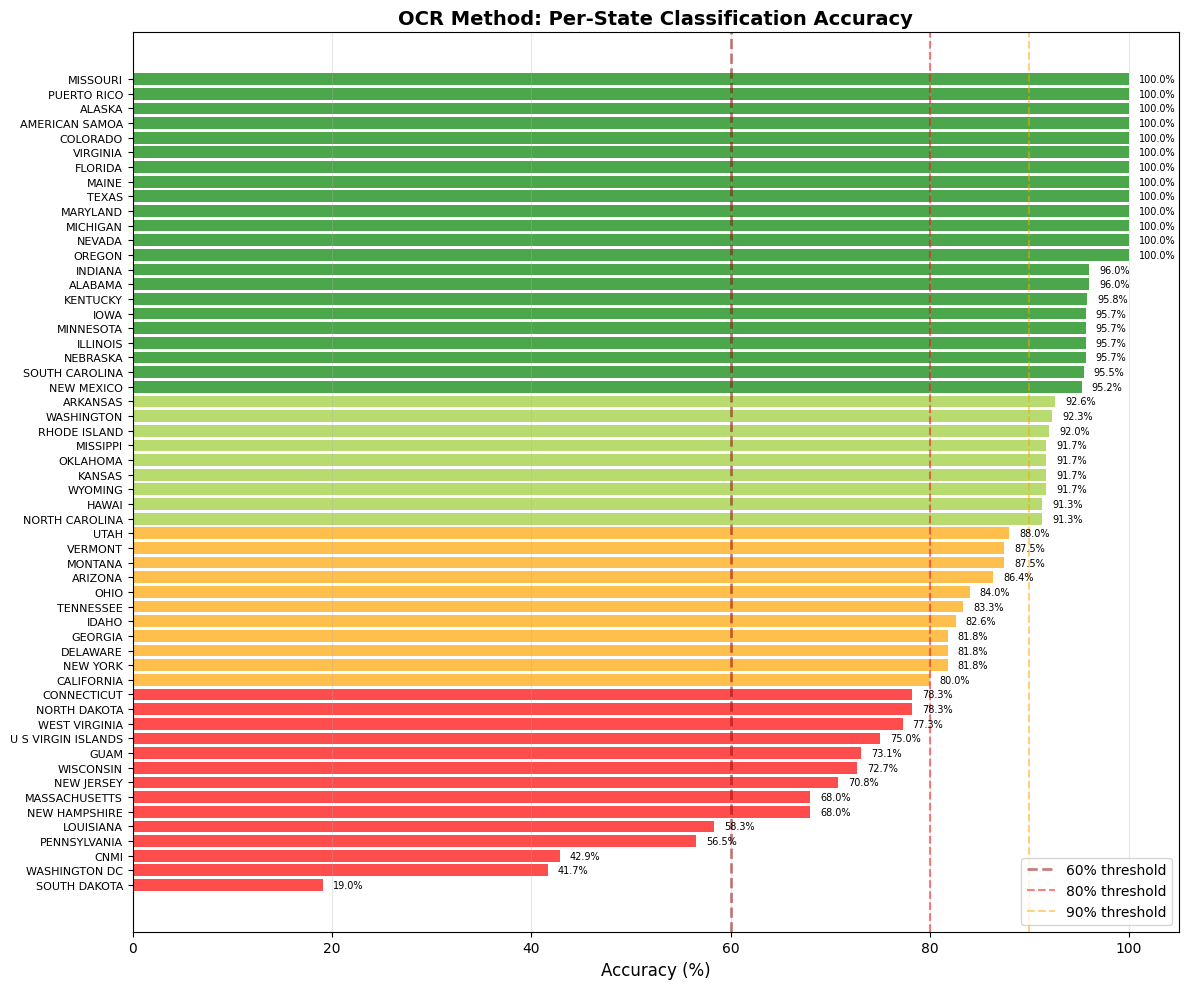


OCR Accuracy Statistics:
Mean: 85.57%
Std: 16.52%
Min: 19.05% (SOUTH DAKOTA)
Max: 100.00% (ALASKA)
States below 60%: 5
States below 80%: 14
States at 100%: 13

COMPARISON:
OCR Baseline Accuracy: 0.8594346829640948
Trained model accuracy
Model loaded successfully from plate_classifier_better_split.pth

Overall Test Accuracy: 0.9213 (92.13%)
Correct: 1206/1309

Per-Class Accuracy:
------------------------------------------------------------
Class                Accuracy   Correct/Total  
------------------------------------------------------------
ALABAMA              0.8400 (84.00%)   21/25 
ALASKA               0.9167 (91.67%)   22/24 
AMERICAN SAMOA       0.9565 (95.65%)   22/23 
ARIZONA              0.9545 (95.45%)   21/22 
ARKANSAS             0.9259 (92.59%)   25/27 
CALIFORNIA           0.9200 (92.00%)   23/25 
CNMI                 1.0000 (100.00%)   14/14 
COLORADO             0.9524 (95.24%)   20/21 
CONNECTICUT          0.8696 (86.96%)   20/23 
DELAWARE             0.8636 (86.

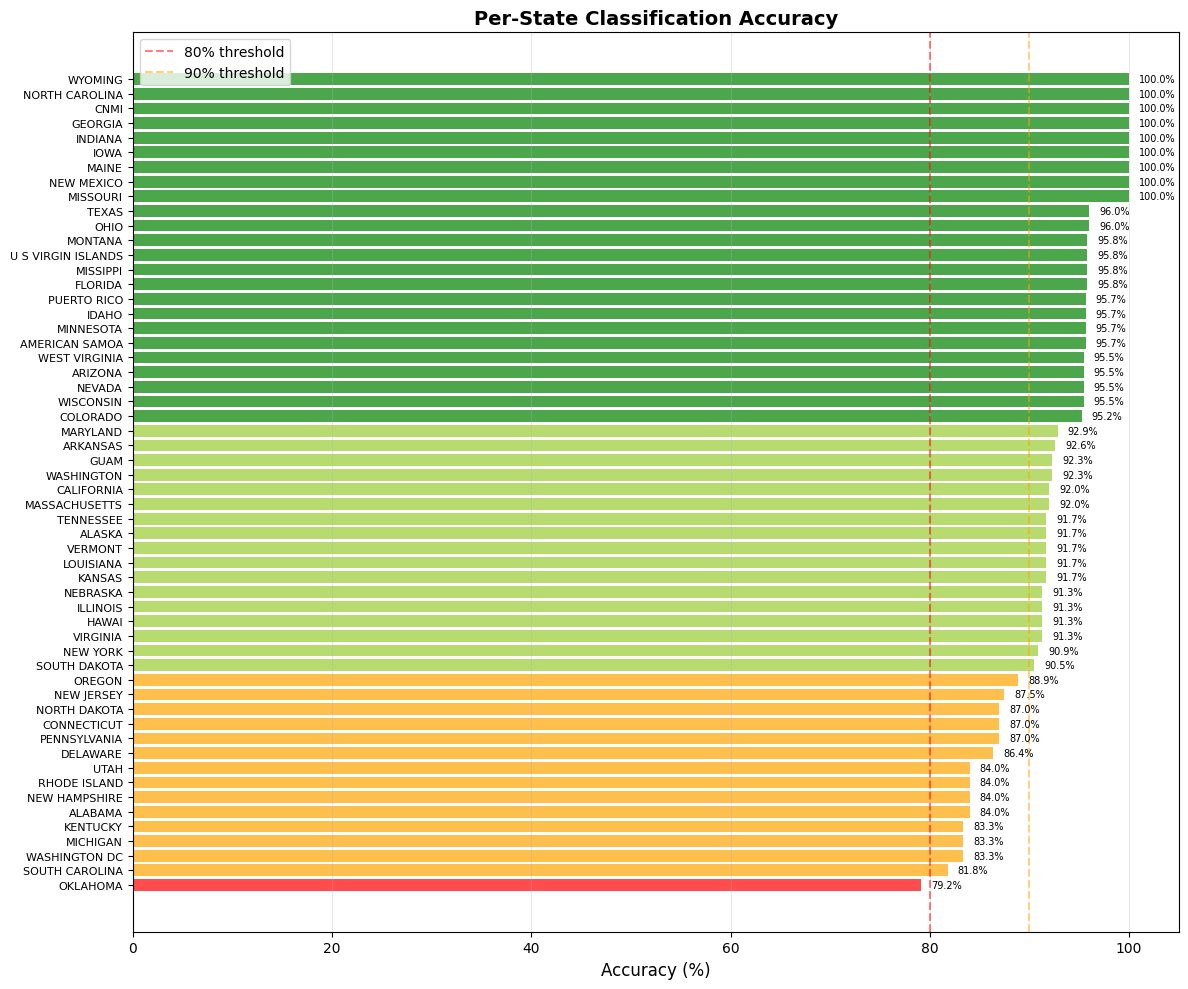

0.9213139801375095

In [65]:
ocr_accuracy, ocr_results = evaluate_ocr_baseline(
        test_dataset, 
        class_names,
        similarity_threshold=0.5
    )
# Analyze errors
analyze_ocr_errors(ocr_results, class_names, n_examples=10)

# Compare with your model
print("\n" + "="*50)
print("COMPARISON:")
print("="*50)
print(f"OCR Baseline Accuracy: {ocr_accuracy}")

print("="*50)
print("Trained model accuracy")
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
loaded_model = load_trained_model("plate_classifier_better_split.pth", len(class_names), device)
# Evaluate your trained model
evaluate_test_set(model_ft, test_loader, class_names)


# Perform classification with zero shot classification using CLIP

In [60]:
import torch
from transformers import CLIPProcessor, CLIPModel

class CLIPZeroShotClassifier:
    def __init__(self, model_name='openai/clip-vit-base-patch32', device='cuda'):
        """
        Initialize CLIP model and create text embeddings for classification
        
        Args:
            model_name: CLIP model from HuggingFace
                - 'openai/clip-vit-base-patch32' (default, fast)
                - 'openai/clip-vit-base-patch16' (better quality)
                - 'openai/clip-vit-large-patch14' (best quality, slower)
            device: 'cuda' or 'cpu'
        """
        self.device = device
        print(f"Loading CLIP model: {model_name}")
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model.eval()
        
        self.text_embeddings = None
        self.class_names = None
        
    def create_text_embeddings(self, text_prompts, class_names):
        """
        Pre-compute text embeddings for all prompts
        
        Args:
            text_prompts: list of text prompts for each class
                         Can be a list of strings (one per class) or 
                         list of lists (multiple prompts per class)
            class_names: list of class names corresponding to prompts
        
        Returns:
            text_embeddings: tensor of shape [num_classes, embedding_dim]
        """
        self.class_names = class_names
        
        # Handle single prompt per class or multiple prompts per class
        if isinstance(text_prompts[0], str):
            # Single prompt per class
            all_prompts = text_prompts
            prompts_per_class = 1
        else:
            # Multiple prompts per class - flatten
            all_prompts = [prompt for prompts in text_prompts for prompt in prompts]
            prompts_per_class = len(text_prompts[0])
        
        print(f"Creating text embeddings for {len(class_names)} classes...")
        print(f"Total prompts: {len(all_prompts)}")
        
        # Process text in batches to avoid memory issues
        batch_size = 32
        all_text_features = []
        
        with torch.no_grad():
            for i in range(0, len(all_prompts), batch_size):
                batch_prompts = all_prompts[i:i+batch_size]
                inputs = self.processor(text=batch_prompts, return_tensors="pt", padding=True, truncation=True)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
                text_features = self.model.get_text_features(**inputs)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
                all_text_features.append(text_features)
        
        # Concatenate all batches
        text_features = torch.cat(all_text_features, dim=0)
        
        # If multiple prompts per class, average them
        if prompts_per_class > 1:
            text_features = text_features.view(len(class_names), prompts_per_class, -1)
            text_features = text_features.mean(dim=1)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        self.text_embeddings = text_features
        print(f"Text embeddings created: {self.text_embeddings.shape}")
        
        return self.text_embeddings
    
    def classify_image(self, image):
        """
        Classify a single image using pre-computed text embeddings
        
        Args:
            image: PIL Image
        
        Returns:
            predicted_class_idx: index of predicted class
            confidence: confidence score (0-1)
            all_probs: probabilities for all classes
        """
        if self.text_embeddings is None:
            raise ValueError("Must call create_text_embeddings first!")
        
        # Preprocess image
        inputs = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Encode image
        with torch.no_grad():
            image_features = self.model.get_image_features(**inputs)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Calculate similarity with all text embeddings
        similarity = (100.0 * image_features @ self.text_embeddings.T).softmax(dim=-1)
        
        # Get prediction
        confidence, predicted_idx = similarity[0].max(dim=0)
        
        return predicted_idx.item(), confidence.item(), similarity[0].cpu().numpy()
    
    def evaluate_dataset(self, dataset, class_names, batch_size=32):
        """
        Evaluate CLIP on entire dataset
        
        Args:
            dataset: PyTorch dataset with (image, label) pairs
            class_names: list of class names
            batch_size: batch size for processing images
        
        Returns:
            accuracy: overall accuracy
            results: detailed results dictionary
        """
        if self.text_embeddings is None:
            raise ValueError("Must call create_text_embeddings first!")
        
        correct = 0
        total = 0
        
        results = {
            'predictions': [],
            'ground_truth': [],
            'confidences': [],
            'all_probs': []
        }
        
        # Track per-class performance
        class_correct = {i: 0 for i in range(len(class_names))}
        class_total = {i: 0 for i in range(len(class_names))}
        
        print(f"Evaluating CLIP on {len(dataset)} images...")
        
        # Process in batches for efficiency
        from torch.utils.data import DataLoader
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for images, labels in tqdm(dataloader):
            # Convert tensors to PIL Images
            pil_images = []
            for img in images:
                # Denormalize if normalized with ImageNet stats
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img * std + mean
                img = torch.clamp(img, 0, 1)
                
                # Convert to PIL
                from torchvision import transforms
                pil_img = transforms.ToPILImage()(img)
                pil_images.append(pil_img)
            
            # Process batch of images
            inputs = self.processor(images=pil_images, return_tensors="pt", padding=True)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            # Encode images
            with torch.no_grad():
                image_features = self.model.get_image_features(**inputs)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            # Calculate similarity with all text embeddings
            similarity = (100.0 * image_features @ self.text_embeddings.T).softmax(dim=-1)
            
            # Get predictions
            confidences, pred_indices = similarity.max(dim=1)
            
            # Store results for each image in batch
            for i in range(len(labels)):
                pred_idx = pred_indices[i].item()
                true_label = labels[i].item()
                confidence = confidences[i].item()
                all_probs = similarity[i].cpu().numpy()
                
                results['predictions'].append(pred_idx)
                results['ground_truth'].append(true_label)
                results['confidences'].append(confidence)
                results['all_probs'].append(all_probs)
                
                # Update counts
                class_total[true_label] += 1
                if pred_idx == true_label:
                    correct += 1
                    class_correct[true_label] += 1
                
                total += 1
        
        # Calculate metrics
        accuracy = correct / total if total > 0 else 0
        
        print(f"\n{'='*60}")
        print(f"CLIP Zero-Shot Results:")
        print(f"{'='*60}")
        print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Correct: {correct}/{total}")
        print(f"{'='*60}")
        
        # Per-class accuracy
        print(f"\nPer-Class Accuracy:")
        print(f"{'-'*60}")
        print(f"{'Class':<20s} {'Accuracy':<10s} {'Correct/Total':<15s}")
        print(f"{'-'*60}")
        
        for i, class_name in enumerate(class_names):
            if class_total[i] > 0:
                class_acc = class_correct[i] / class_total[i]
                print(f"{class_name:<20s} {class_acc:.4f} ({class_acc*100:>5.2f}%)  {class_correct[i]:>3d}/{class_total[i]:<3d}")
            else:
                print(f"{class_name:<20s} {'N/A':<10s} {'0/0':<15s}")
        
        print(f"{'-'*60}\n")

        plot_per_class_accuracy(class_correct, class_total, class_names)
        
        return accuracy, results


# ============================================================================
# Example Usage
# ============================================================================

def create_license_plate_prompts(class_names):
    """
    Create text prompts for license plate classification
    
    You can customize these prompts based on your specific task
    """
    
    # Strategy 1: Simple state name prompts
    simple_prompts = [f"a license plate from {state}" for state in class_names]
    
    # Strategy 2: Multiple prompts per class for better accuracy
    multi_prompts = []
    for state in class_names:
        prompts = [
            f"a license plate from {state}",
            f"a {state} license plate",
            f"a {state} state license plate",
            f"{state} vehicle registration plate",
            f"a car plate from {state}"
        ]
        multi_prompts.append(prompts)
    
    # Strategy 3: More descriptive prompts
    descriptive_prompts = [
        f"a photo of a license plate from {state} state" 
        for state in class_names
    ]
    
    # Strategy 4: Direct state names (sometimes works best for simple tasks)
    direct_prompts = [state for state in class_names]
    
    return simple_prompts, multi_prompts, descriptive_prompts, direct_prompts


evaluate results of zero shot classification

Loading CLIP model: openai/clip-vit-base-patch32
Creating text embeddings for 56 classes...
Total prompts: 56
Text embeddings created: torch.Size([56, 512])
Evaluating CLIP on 1309 images...


100%|██████████| 41/41 [00:07<00:00,  5.22it/s]



CLIP Zero-Shot Results:
Overall Accuracy: 0.8831 (88.31%)
Correct: 1156/1309

Per-Class Accuracy:
------------------------------------------------------------
Class                Accuracy   Correct/Total  
------------------------------------------------------------
ALABAMA              0.9600 (96.00%)   24/25 
ALASKA               1.0000 (100.00%)   24/24 
AMERICAN SAMOA       0.9565 (95.65%)   22/23 
ARIZONA              0.8182 (81.82%)   18/22 
ARKANSAS             1.0000 (100.00%)   27/27 
CALIFORNIA           0.9600 (96.00%)   24/25 
CNMI                 0.2857 (28.57%)    4/14 
COLORADO             0.9524 (95.24%)   20/21 
CONNECTICUT          0.6957 (69.57%)   16/23 
DELAWARE             0.8182 (81.82%)   18/22 
FLORIDA              0.9583 (95.83%)   23/24 
GEORGIA              0.8636 (86.36%)   19/22 
GUAM                 1.0000 (100.00%)   26/26 
HAWAI                0.9130 (91.30%)   21/23 
IDAHO                0.9565 (95.65%)   22/23 
ILLINOIS             0.9130 (91.30%)  

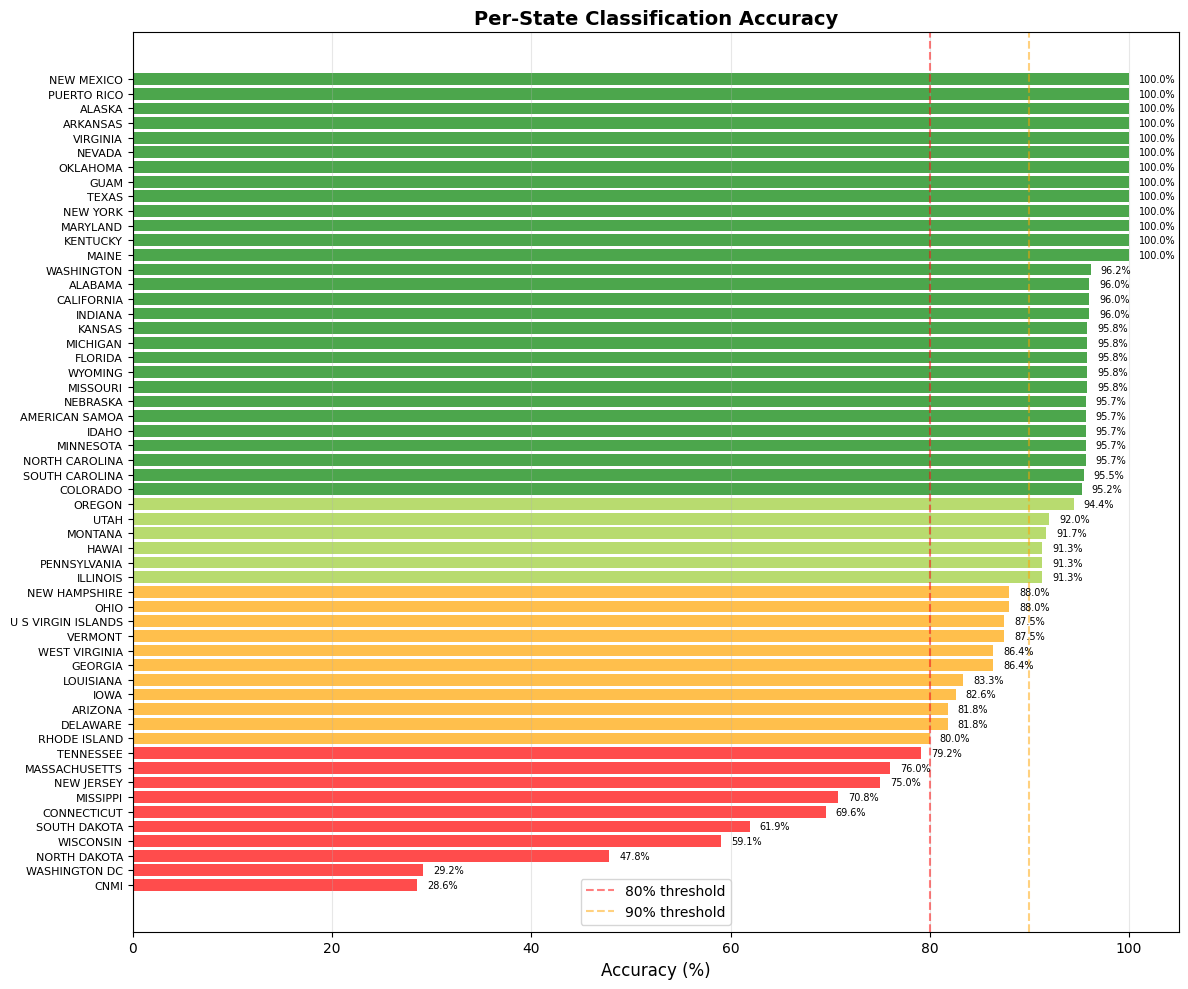


MODEL COMPARISON:
CLIP Zero-Shot:      0.8831 (88.31%)


In [61]:
clip_classifier = CLIPZeroShotClassifier(
        model_name='openai/clip-vit-base-patch32',  # or 'openai/clip-vit-large-patch14'
        device=device
    )
# Create prompts (choose one strategy)
simple_prompts, multi_prompts, descriptive_prompts, direct_prompts = create_license_plate_prompts(class_names)

# Option 1: Use simple prompts (one per class)
clip_classifier.create_text_embeddings(simple_prompts, class_names)

# Option 2: Use multiple prompts per class (often better accuracy)
# clip_classifier.create_text_embeddings(multi_prompts, class_names)

# Option 3: Use descriptive prompts
# clip_classifier.create_text_embeddings(descriptive_prompts, class_names)

# Option 4: Use direct state names
# clip_classifier.create_text_embeddings(direct_prompts, class_names)

# Evaluate on test set (batched for efficiency)
clip_accuracy, clip_results = clip_classifier.evaluate_dataset(
    test_dataset, 
    class_names,
    batch_size=32
)

print("\n" + "="*60)
print("MODEL COMPARISON:")
print("="*60)
print(f"CLIP Zero-Shot:      {clip_accuracy:.4f} ({clip_accuracy*100:.2f}%)")
# print(f"Trained ResNet:      {model_accuracy:.4f} ({model_accuracy*100:.2f}%)")
# print(f"Difference:          {(model_accuracy - clip_accuracy)*100:+.2f}%")
print("="*60)

# Perform few shot classification with CLIP

here we extend the clip implementation by running through the training data and when a result is misclassified, we add that embedding to our comparison embeddings

In [62]:
from collections import defaultdict

class CLIPFewShotClassifier:
    def __init__(self, model_name='openai/clip-vit-base-patch32', device='cuda'):
        """
        Initialize CLIP model for few-shot learning with adaptive embedding collection
        
        Args:
            model_name: CLIP model from HuggingFace
            device: 'cuda' or 'cpu'
        """
        self.device = device
        print(f"Loading CLIP model: {model_name}")
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model.eval()
        
        # Store embeddings for each class
        self.class_embeddings = defaultdict(list)  # class_idx -> list of embeddings
        self.class_names = None
        
    def add_text_embeddings(self, text_prompts, class_names):
        """
        Add initial text embeddings for all classes
        
        Args:
            text_prompts: list of text prompts (one per class or list of lists)
            class_names: list of class names
        """
        self.class_names = class_names
        
        # Handle single prompt per class or multiple prompts per class
        if isinstance(text_prompts[0], str):
            all_prompts = text_prompts
            prompts_per_class = 1
        else:
            all_prompts = [prompt for prompts in text_prompts for prompt in prompts]
            prompts_per_class = len(text_prompts[0])
        
        print(f"Adding text embeddings for {len(class_names)} classes...")
        
        # Process text in batches
        batch_size = 32
        all_text_features = []
        
        with torch.no_grad():
            for i in range(0, len(all_prompts), batch_size):
                batch_prompts = all_prompts[i:i+batch_size]
                inputs = self.processor(text=batch_prompts, return_tensors="pt", padding=True, truncation=True)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
                text_features = self.model.get_text_features(**inputs)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
                all_text_features.append(text_features)
        
        text_features = torch.cat(all_text_features, dim=0)
        
        # Add text embeddings to each class
        if prompts_per_class > 1:
            for class_idx in range(len(class_names)):
                start_idx = class_idx * prompts_per_class
                end_idx = start_idx + prompts_per_class
                class_text_embeddings = text_features[start_idx:end_idx]
                self.class_embeddings[class_idx].extend(class_text_embeddings)
        else:
            for class_idx, embedding in enumerate(text_features):
                self.class_embeddings[class_idx].append(embedding)
        
        print(f"Text embeddings added. Total embeddings per class:")
        for class_idx, class_name in enumerate(class_names):
            print(f"  {class_name}: {len(self.class_embeddings[class_idx])} embeddings")
    
    def add_image_embedding(self, image, class_idx):
        """
        Add an image embedding to a specific class
        
        Args:
            image: PIL Image
            class_idx: index of the class this image belongs to
        """
        # Process image
        inputs = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Encode image
        with torch.no_grad():
            image_features = self.model.get_image_features(**inputs)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Add to class embeddings
        self.class_embeddings[class_idx].append(image_features[0])
    
    def classify_image(self, image):
        """
        Classify image by comparing against ALL embeddings (not averaged)
        Uses max similarity across all embeddings in each class
        
        Args:
            image: PIL Image
        
        Returns:
            predicted_class_idx, confidence, all_probs
        """
        # Process image
        inputs = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Encode image
        with torch.no_grad():
            image_features = self.model.get_image_features(**inputs)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Calculate max similarity for each class
        class_similarities = []
        for class_idx in range(len(self.class_names)):
            if len(self.class_embeddings[class_idx]) > 0:
                # Stack all embeddings for this class
                class_embs = torch.stack(self.class_embeddings[class_idx])
                
                # Calculate similarity with all embeddings in this class
                similarities = image_features @ class_embs.T  # [1, num_embeddings_in_class]
                
                # Take max similarity for this class
                max_similarity = similarities.max().item()
                class_similarities.append(max_similarity)
            else:
                # No embeddings for this class
                class_similarities.append(-float('inf'))
        
        # Convert to tensor and apply softmax
        class_similarities = torch.tensor(class_similarities).to(self.device)
        similarity = (100.0 * class_similarities).softmax(dim=-1)
        
        # Get prediction
        confidence, predicted_idx = similarity.max(dim=0)
        
        return predicted_idx.item(), confidence.item(), similarity.cpu().numpy()
    
    def train_with_adaptive_embeddings(self, train_dataset, class_names, max_images_per_class=None):
        """
        Train on dataset by adding misclassified images to embedding collection
        
        Args:
            train_dataset: PyTorch dataset with (image, label) pairs
            class_names: list of class names
            max_images_per_class: maximum number of image embeddings to add per class (None = unlimited)
        
        Returns:
            training_accuracy: final accuracy on training set
            history: training statistics
        """
        if self.class_names is None:
            self.class_names = class_names
        
        print(f"\n{'='*60}")
        print(f"Training with Adaptive Embeddings")
        print(f"{'='*60}")
        
        correct = 0
        total = 0
        misclassifications_added = defaultdict(int)
        
        history = {
            'correct': [],
            'total': [],
            'accuracy': [],
            'embeddings_per_class': []
        }
        
        from torch.utils.data import DataLoader
        dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Process one at a time
        
        for idx, (image, label) in enumerate(tqdm(dataloader, desc="Processing training data")):
            # Convert tensor to PIL Image
            img = image[0]
            true_label = label[0].item()
            
            # Denormalize
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            # Convert to PIL
            from torchvision import transforms
            pil_img = transforms.ToPILImage()(img)
            
            # Classify with current embeddings
            pred_idx, confidence, _ = self.classify_image(pil_img)
            
            # Check if correct
            if pred_idx == true_label:
                correct += 1
            else:
                # Misclassification! Add this image embedding to correct class
                if max_images_per_class is None or misclassifications_added[true_label] < max_images_per_class:
                    self.add_image_embedding(pil_img, true_label)
                    misclassifications_added[true_label] += 1
            
            total += 1
            
            # Log progress every 100 images
            if (idx + 1) % 100 == 0:
                current_acc = correct / total
                history['correct'].append(correct)
                history['total'].append(total)
                history['accuracy'].append(current_acc)
                
                embeddings_count = {name: len(self.class_embeddings[i]) 
                                   for i, name in enumerate(class_names)}
                history['embeddings_per_class'].append(embeddings_count.copy())
        
        final_accuracy = correct / total
        
        print(f"\n{'='*60}")
        print(f"Training Complete")
        print(f"{'='*60}")
        print(f"Final Training Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
        print(f"Correct: {correct}/{total}")
        print(f"\nImage embeddings added per class:")
        for class_idx, class_name in enumerate(class_names):
            text_emb_count = sum(1 for _ in self.class_embeddings[class_idx] 
                                if len(self.class_embeddings) <= len(class_names))  # Rough estimate
            image_emb_count = misclassifications_added[class_idx]
            total_emb_count = len(self.class_embeddings[class_idx])
            print(f"  {class_name}: {image_emb_count} image embeddings added (total: {total_emb_count})")
        print(f"{'='*60}\n")
        
        return final_accuracy, history
    
    def evaluate_dataset(self, dataset, class_names, batch_size=32):
        """
        Evaluate on test dataset using current embeddings
        
        Args:
            dataset: PyTorch dataset
            class_names: list of class names
            batch_size: batch size for processing
        
        Returns:
            accuracy, results
        """
        correct = 0
        total = 0
        
        results = {
            'predictions': [],
            'ground_truth': [],
            'confidences': [],
            'all_probs': []
        }
        
        class_correct = {i: 0 for i in range(len(class_names))}
        class_total = {i: 0 for i in range(len(class_names))}
        
        print(f"Evaluating on {len(dataset)} images...")
        
        from torch.utils.data import DataLoader
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
        
        for image, label in tqdm(dataloader):
            # Convert tensor to PIL Image
            img = image[0]
            true_label = label[0].item()
            
            # Denormalize
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            # Convert to PIL
            from torchvision import transforms
            pil_img = transforms.ToPILImage()(img)
            
            # Classify
            pred_idx, confidence, all_probs = self.classify_image(pil_img)
            
            # Store results
            results['predictions'].append(pred_idx)
            results['ground_truth'].append(true_label)
            results['confidences'].append(confidence)
            results['all_probs'].append(all_probs)
            
            # Update counts
            class_total[true_label] += 1
            if pred_idx == true_label:
                correct += 1
                class_correct[true_label] += 1
            
            total += 1
        
        accuracy = correct / total
        
        print(f"\n{'='*60}")
        print(f"Test Results:")
        print(f"{'='*60}")
        print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Correct: {correct}/{total}")
        print(f"{'='*60}")
        
        # Per-class accuracy
        print(f"\nPer-Class Accuracy:")
        print(f"{'-'*60}")
        print(f"{'Class':<20s} {'Accuracy':<10s} {'Correct/Total':<15s}")
        print(f"{'-'*60}")
        
        for i, class_name in enumerate(class_names):
            if class_total[i] > 0:
                class_acc = class_correct[i] / class_total[i]
                print(f"{class_name:<20s} {class_acc:.4f} ({class_acc*100:>5.2f}%)  {class_correct[i]:>3d}/{class_total[i]:<3d}")
            else:
                print(f"{class_name:<20s} {'N/A':<10s} {'0/0':<15s}")
        
        print(f"{'-'*60}\n")

        plot_per_class_accuracy(class_correct, class_total, class_names)
        
        return accuracy, results


# ============================================================================
# Example Usage
# ============================================================================

def create_license_plate_prompts(class_names):
    """Create text prompts for license plate classification"""
    
    # Simple prompts work well for starting
    simple_prompts = [f"a license plate from {state}" for state in class_names]
    
    # Multiple prompts per class
    multi_prompts = []
    for state in class_names:
        prompts = [
            f"a license plate from {state}",
            f"a {state} license plate",
            f"{state}",
        ]
        multi_prompts.append(prompts)
    
    return simple_prompts, multi_prompts

test few shot classification

Loading CLIP model: openai/clip-vit-base-patch32
Adding text embeddings for 56 classes...
Text embeddings added. Total embeddings per class:
  ALABAMA: 1 embeddings
  ALASKA: 1 embeddings
  AMERICAN SAMOA: 1 embeddings
  ARIZONA: 1 embeddings
  ARKANSAS: 1 embeddings
  CALIFORNIA: 1 embeddings
  CNMI: 1 embeddings
  COLORADO: 1 embeddings
  CONNECTICUT: 1 embeddings
  DELAWARE: 1 embeddings
  FLORIDA: 1 embeddings
  GEORGIA: 1 embeddings
  GUAM: 1 embeddings
  HAWAI: 1 embeddings
  IDAHO: 1 embeddings
  ILLINOIS: 1 embeddings
  INDIANA: 1 embeddings
  IOWA: 1 embeddings
  KANSAS: 1 embeddings
  KENTUCKY: 1 embeddings
  LOUISIANA: 1 embeddings
  MAINE: 1 embeddings
  MARYLAND: 1 embeddings
  MASSACHUSETTS: 1 embeddings
  MICHIGAN: 1 embeddings
  MINNESOTA: 1 embeddings
  MISSIPPI: 1 embeddings
  MISSOURI: 1 embeddings
  MONTANA: 1 embeddings
  NEBRASKA: 1 embeddings
  NEVADA: 1 embeddings
  NEW HAMPSHIRE: 1 embeddings
  NEW JERSEY: 1 embeddings
  NEW MEXICO: 1 embeddings
  NEW YORK: 1 e

Processing training data: 100%|██████████| 6104/6104 [03:31<00:00, 28.82it/s]



Training Complete
Final Training Accuracy: 0.5508 (55.08%)
Correct: 3362/6104

Image embeddings added per class:
  ALABAMA: 51 image embeddings added (total: 52)
  ALASKA: 36 image embeddings added (total: 37)
  AMERICAN SAMOA: 29 image embeddings added (total: 30)
  ARIZONA: 59 image embeddings added (total: 60)
  ARKANSAS: 54 image embeddings added (total: 55)
  CALIFORNIA: 61 image embeddings added (total: 62)
  CNMI: 36 image embeddings added (total: 37)
  COLORADO: 53 image embeddings added (total: 54)
  CONNECTICUT: 57 image embeddings added (total: 58)
  DELAWARE: 43 image embeddings added (total: 44)
  FLORIDA: 53 image embeddings added (total: 54)
  GEORGIA: 62 image embeddings added (total: 63)
  GUAM: 37 image embeddings added (total: 38)
  HAWAI: 23 image embeddings added (total: 24)
  IDAHO: 48 image embeddings added (total: 49)
  ILLINOIS: 51 image embeddings added (total: 52)
  INDIANA: 59 image embeddings added (total: 60)
  IOWA: 47 image embeddings added (total: 48)


100%|██████████| 1309/1309 [00:51<00:00, 25.21it/s]



Test Results:
Overall Accuracy: 0.8633 (86.33%)
Correct: 1130/1309

Per-Class Accuracy:
------------------------------------------------------------
Class                Accuracy   Correct/Total  
------------------------------------------------------------
ALABAMA              0.9600 (96.00%)   24/25 
ALASKA               0.7917 (79.17%)   19/24 
AMERICAN SAMOA       0.7391 (73.91%)   17/23 
ARIZONA              0.9091 (90.91%)   20/22 
ARKANSAS             0.9630 (96.30%)   26/27 
CALIFORNIA           0.7200 (72.00%)   18/25 
CNMI                 0.7143 (71.43%)   10/14 
COLORADO             0.9048 (90.48%)   19/21 
CONNECTICUT          0.8696 (86.96%)   20/23 
DELAWARE             0.9545 (95.45%)   21/22 
FLORIDA              0.9583 (95.83%)   23/24 
GEORGIA              0.5909 (59.09%)   13/22 
GUAM                 0.8846 (88.46%)   23/26 
HAWAI                1.0000 (100.00%)   23/23 
IDAHO                0.7826 (78.26%)   18/23 
ILLINOIS             0.8696 (86.96%)   20/23 
INDI

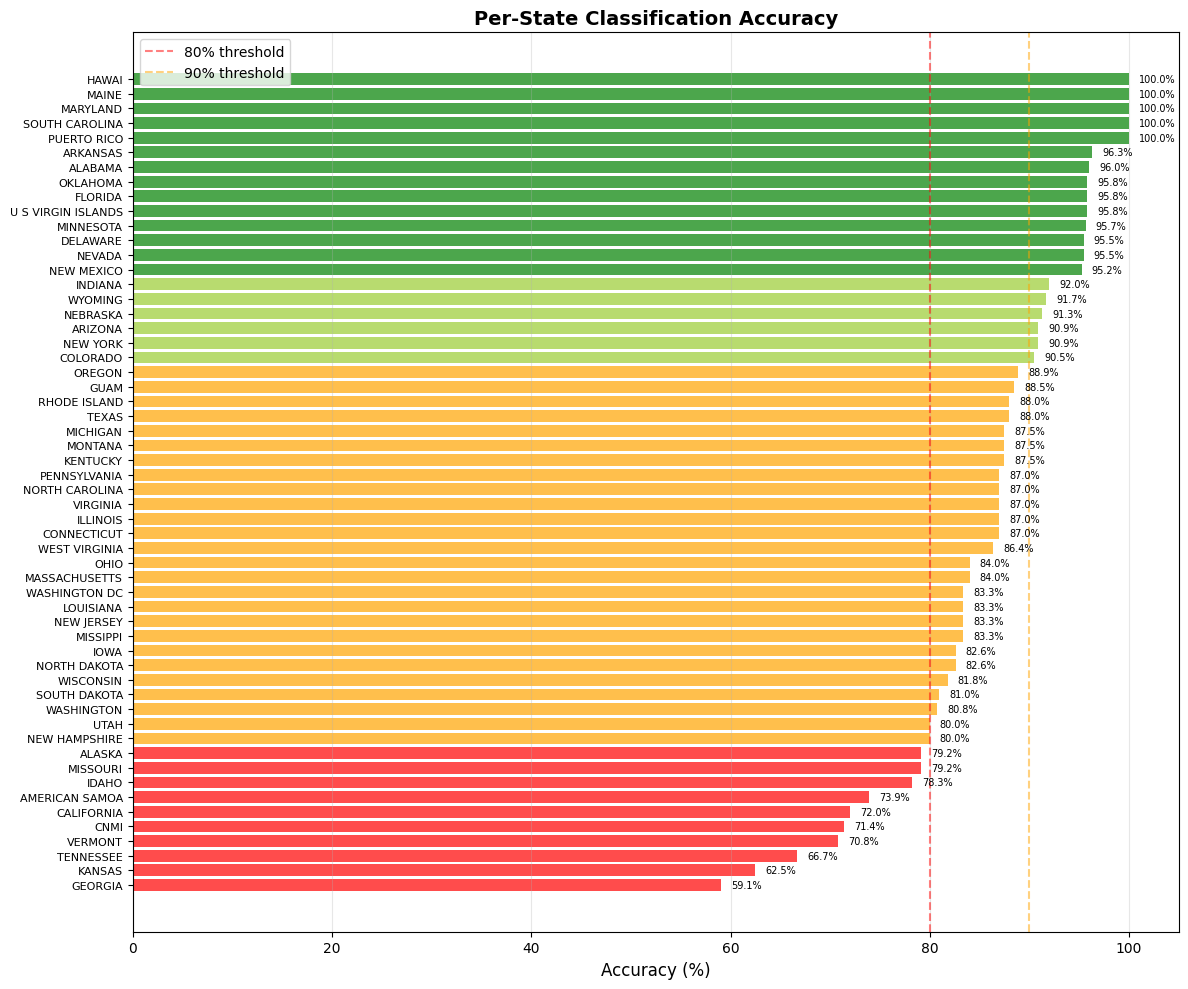


FINAL COMPARISON:
Test Accuracy:     0.8633 (86.33%)


In [63]:
clip_few_shot = CLIPFewShotClassifier(
        model_name='openai/clip-vit-base-patch32',
        device=device
)
    
# Add initial text embeddings
simple_prompts, multi_prompts = create_license_plate_prompts(class_names)
clip_few_shot.add_text_embeddings(simple_prompts, class_names)

# Train adaptively on training data (adds misclassified images)
train_accuracy, train_history = clip_few_shot.train_with_adaptive_embeddings(
    train_dataset,
    class_names,
    max_images_per_class=None  # Limit to 50 images per class, or None for unlimited
)

# Evaluate on test set with enhanced embeddings
test_accuracy, test_results = clip_few_shot.evaluate_dataset(test_dataset, class_names)

print("\n" + "="*60)
print("FINAL COMPARISON:")
print("="*60)
print(f"Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*60)